In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
image_dir = Path('C:/Users/SUYASH/JUPYTER/SIH/Practice/Fish_Dataset/Fish_Dataset')


In [5]:
# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

filepaths.size

18000

In [6]:
# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df

,Filepath,Label
0,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Black Sea Sprat
1,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Black Sea Sprat
2,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Black Sea Sprat
3,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Black Sea Sprat
4,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Black Sea Sprat
...,...,...
17995,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Trout GT
17996,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Trout GT
17997,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Trout GT
17998,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Trout GT


In [7]:
# Drop GT images
image_df['Label'] = image_df['Label'].apply(lambda x: np.NaN if x[-2:] == 'GT' else x)
image_df = image_df.dropna(axis=0)
image_df

,Filepath,Label
0,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Black Sea Sprat
1,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Black Sea Sprat
2,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Black Sea Sprat
3,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Black Sea Sprat
4,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Black Sea Sprat
...,...,...
16995,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Trout
16996,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Trout
16997,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Trout
16998,C:\Users\SUYASH\JUPYTER\SIH\Practice\Fish_Data...,Trout


In [8]:
# Sample 200 images from each class
samples = []

for category in image_df['Label'].unique():
    category_slice = image_df.query("Label == @category")
    samples.append(category_slice.sample(40, random_state=1))

image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [9]:
image_df.size

720

In [11]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [12]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [13]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 201 validated image filenames belonging to 9 classes.
Found 50 validated image filenames belonging to 9 classes.
Found 109 validated image filenames belonging to 9 classes.


In [14]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False
type(pretrained_model)

keras.engine.functional.Functional

# training

In [15]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [16]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
7/7 [==============================] - 8s 919ms/step - loss: 2.0612 - accuracy: 0.3035 - val_loss: 1.4341 - val_accuracy: 0.6000
Epoch 2/10
7/7 [==============================] - 5s 749ms/step - loss: 1.0554 - accuracy: 0.7811 - val_loss: 0.7971 - val_accuracy: 0.8000
Epoch 3/10
7/7 [==============================] - 6s 787ms/step - loss: 0.4143 - accuracy: 0.9502 - val_loss: 0.3577 - val_accuracy: 0.9600
Epoch 4/10
7/7 [==============================] - 6s 779ms/step - loss: 0.1629 - accuracy: 0.9751 - val_loss: 0.2919 - val_accuracy: 0.9400
Epoch 5/10
7/7 [==============================] - 5s 781ms/step - loss: 0.0702 - accuracy: 1.0000 - val_loss: 0.2739 - val_accuracy: 0.9400
Epoch 6/10
7/7 [==============================] - 5s 764ms/step - loss: 0.0345 - accuracy: 1.0000 - val_loss: 0.1476 - val_accuracy: 0.9800
Epoch 7/10
7/7 [==============================] - 6s 779ms/step - loss: 0.0213 - accuracy: 1.0000 - val_loss: 0.1491 - val_accuracy: 0.9800
Epoch 8/10
7/7 [====

In [17]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.11050
Test Accuracy: 96.33%


In [29]:
# saving and loading the model weights

# save model
#model.save_weights('./Weights')
print('Model Saved!')

# load model
savedModel = model.load_weights('Weights')
print('Model Loaded!')


Model Saved!
Model Loaded!


In [18]:
from tensorflow.keras.models import load_model

In [19]:
# saving and loading the .h5 model

# save model
model.save('fishModel.h5')
print('Model Saved!')

# load model
savedModel=load_model('fishModel.h5')
savedModel.summary()


Model Saved!
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [20]:
type(savedModel)
results = savedModel.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.11050
Test Accuracy: 96.33%


In [20]:
#our classification
classification = ['Black Sea Sprat', 'Gilt-Head Bream', "Hourse Mackerel", 'Red Mullet', ' Red Sea Bream', 'Sea Bass', 'Shrimp', 'Stripped Red Mullet', 'Trout']

In [21]:
import imageio as iio

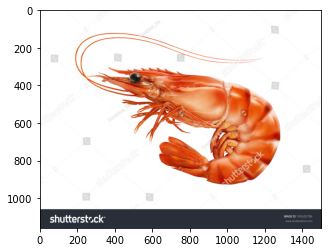

In [23]:
img = iio.imread('shrimp.png')
img2 = plt.imshow(img)

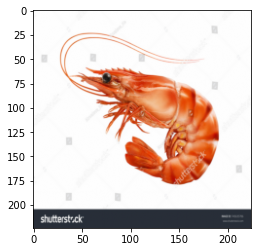

In [24]:
from skimage.transform import resize
resized_image = resize(img, (224,224,3))
img = plt.imshow(resized_image)

In [25]:
pred = savedModel.predict(np.array([resized_image]))
arr = pred[0]
print(arr)
x = np.where(arr == arr.max())

classification[x[0][0]]

[1.3094905e-07 1.3973755e-07 3.2268948e-05 2.3949624e-03 2.2682369e-04
 6.9400594e-05 9.9713242e-01 9.0020534e-05 5.3832719e-05]


'Shrimp'